# Intuition



fine-mapping --- summary statistics and LD

# Notations

## Introduction to Fine-Mapping

In genome-wide association studies (GWAS), as discussed in lecture 3.1, we often obtain marginal estimates of the effect size for each genetic variant, typically from univariate regression models. However, these marginal estimates do not account for the potential correlation between variants, i.e., LD that we discussed in lecture 1.2. 

The existence of LD can lead to bias of estimates of effect size in GWAS, where multiple correlated variants may be associated with the trait, and the true causal variant is obscured by these correlations.

Fine-mapping is the process of refining the association signals from GWAS to identify the most likely causal variant within a region of high LD. This involves considering the **genetic correlation** between variants and accounting for the LD structure to better understand the genetic architecture of traits.


## Steps in Fine-Mapping

1. **Identify the Associated Region**  
   First, identify the genomic region associated with the trait (from GWAS). This region usually contains many correlated SNPs.

2. **Look at the LD Structure**  
   Examine the **linkage disequilibrium (LD)** structure to see how the SNPs in the region are correlated with each other.

3. **Estimate the Likelihood of Causality for Each SNP**  
   Fine-mapping methods (like Bayesian models) calculate the probability that each SNP in the region is causal, considering both the statistical association and the LD patterns.

4. **Rank and Prioritize Causal Variants**  
   The SNPs are ranked based on their likelihood of being causal, with the highest probability indicating the most likely causal variant.

5. **Refine the Causal Variant**  
   Fine-mapping narrows down the list of candidate SNPs, highlighting the most likely causal variants for further study.


## Difference Between OLS Estimate and Fine-Mapping

- **OLS Estimate**:  
  - Estimates the effect of each SNP on the trait independently, assuming that SNPs are not correlated (no linkage disequilibrium, LD).
  - Provides marginal effect sizes without considering potential correlations between SNPs.
  - Useful for initial screening but may mislead when SNPs are in LD.

- **Fine-Mapping**:  
  - Refines the identification of causal variants by considering both the association signal and LD between SNPs.
  - Uses statistical models (like Bayesian methods) to estimate the probability of each SNP being causal, accounting for correlation among variants.
  - More accurate for identifying the true causal SNP(s) within a region.

### Key Difference:
OLS gives independent estimates without considering LD, while fine-mapping accounts for LD and provides a refined likelihood of causality for each SNP.


# Example

Reference susie: https://stephenslab.github.io/susieR/articles/finemapping.html

In [55]:
rm(list=ls())
library(susieR)
library(corrplot)
data(N3finemapping)
attach(N3finemapping)

The following objects are masked from N3finemapping (pos = 3):

    allele_freq, chrom, pos, residual_variance, true_coef, V, X, Y




In [56]:
dim(Y)

[1] 574   2

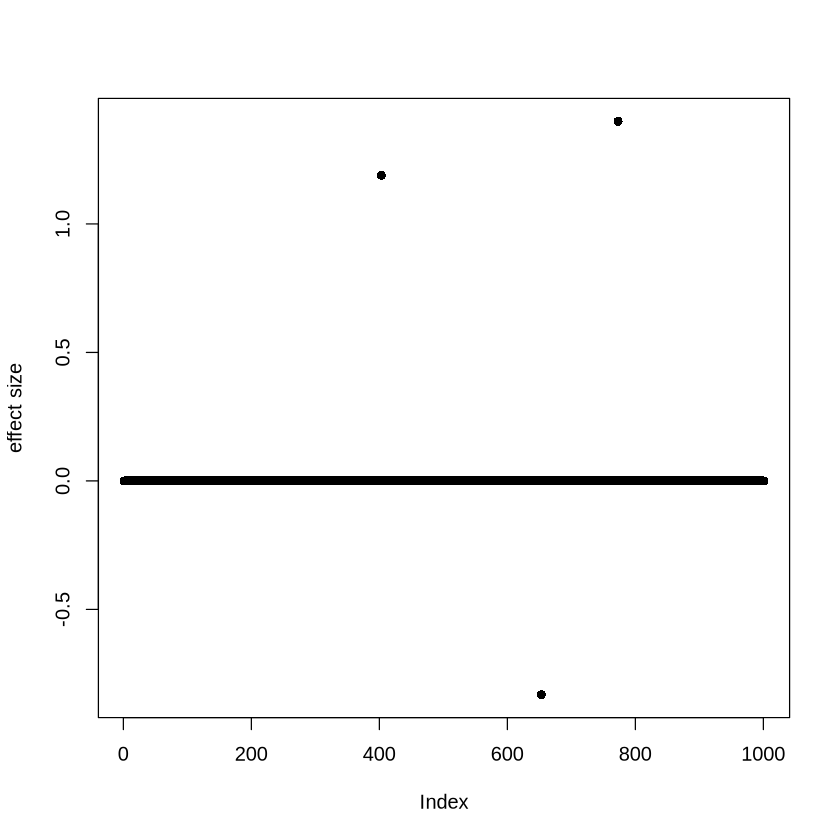

In [57]:
b <- true_coef[,1]
plot(b, pch=16, ylab='effect size')

In [58]:
which(b != 0)

[1] 403 653 773

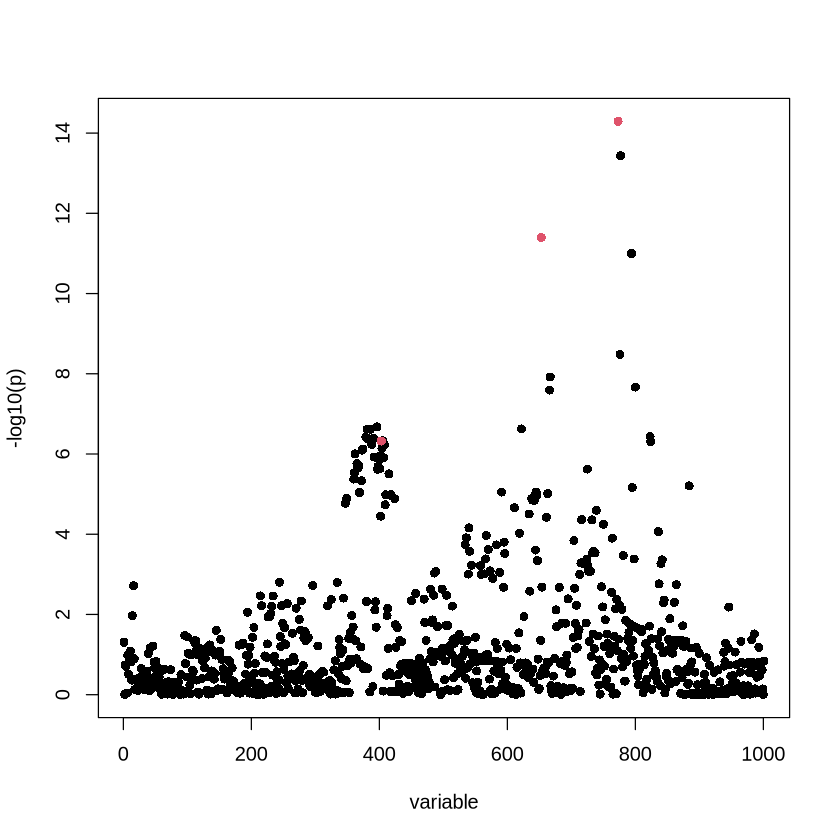

In [59]:
sumstats <- univariate_regression(X, Y[,1])
z_scores <- sumstats$betahat / sumstats$sebetahat
susie_plot(z_scores, y = "z", b=b)

Note that the `univariate_regression` is exactly the same as we did before -- running the simplest linear regression on the trait with each SNP respectively:

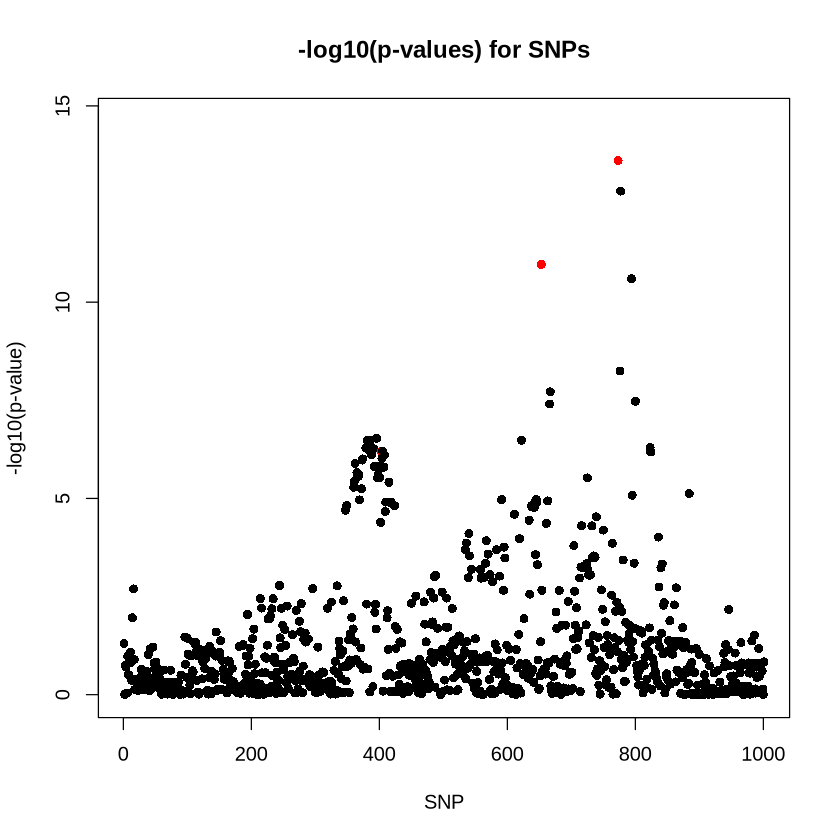

In [60]:
# Initialize a matrix or data frame to store the summary statistics for each variant
summary_stats <- data.frame(
  Variant = rep(1:ncol(X)),
  Estimate = numeric(ncol(X)),
  Std.Error = numeric(ncol(X)),
  t.Value = numeric(ncol(X)),
  P.Value = numeric(ncol(X))
)

# Loop over each column (variant) in X
for (i in 1:ncol(X)) {
  # Fit a linear model for each variant (marginal regression)
  model <- lm(Y[,1] ~ X[,i])
  
  # Get the summary of the model
  model_summary <- summary(model)
  
  # Extract the coefficients (effect size, SE, t-value, p-value) for the current variant
  summary_stats$Estimate[i] <- model_summary$coefficients[2, 1]  # Effect size (beta)
  summary_stats$Std.Error[i] <- model_summary$coefficients[2, 2]  # Standard error
  summary_stats$t.Value[i] <- model_summary$coefficients[2, 3]    # t-value
  summary_stats$P.Value[i] <- model_summary$coefficients[2, 4]    # p-value
}

# Calculate -log10(p-values)
summary_stats$neg_log10_p <- -log10(summary_stats$P.Value)

# Create a vector indicating which variants are causal (assuming non-zero coefficient means causal)
is_causal <- b != 0

# Set up the colors: black for non-causal, red for causal
colors <- ifelse(is_causal, "red", "black")

# Plot -log10(p-values)
plot(summary_stats$neg_log10_p, 
     main = "-log10(p-values) for SNPs", 
     ylab = "-log10(p-value)", 
     xlab = "SNP", 
     pch = 16,  # Solid dots
     col = colors,  # Color points based on whether they're causal or not
     ylim = c(0, max(summary_stats$neg_log10_p, na.rm = TRUE) + 1))


In [62]:
fitted <- susie(X, Y[,1],
                L = 10,
        verbose = TRUE)

HINT: For an X with many columns, please consider installingthe Rfast package for more efficient credible set (CS)calculations.



[1] "objective:-1380.57545244584"
[1] "objective:-1377.48660917375"
[1] "objective:-1375.85777207917"
[1] "objective:-1375.80892301721"
[1] "objective:-1370.33949333373"
[1] "objective:-1370.19677277264"
[1] "objective:-1370.10919739196"
[1] "objective:-1370.10918017462"
[1] "objective:-1370.10901872278"


In [63]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



In [65]:
sets <- susie_get_cs(fitted,
                     X = X,
             coverage = 0.9,
                     min_abs_corr = 0.1)
print(sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 373 374 379 381 383 384 386 387 388 389 391 392 396 398 399 400 401 403 404
[20] 405 407 408


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.9119572     0.9726283       0.9765888

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9119917

$requested_coverage
[1] 0.9




> slide 206-207 from GW